# Análisis predictivo del consumo eléctrico en la ciudad de Barcelona

El principal objetivo es limpiar los datos generados por parte de el histórico de generación energética de la ciudad de Barcelona y hacer una predicción de la demanda energética en un perído de tiempo especificado.

## 1. Preparación de los datos

Lo primero que debemos hacer es importar y cargar las librerías que utilizaremos en el ejercicio.

*    [pandas](https://pandas.pydata.org/) es una librería de Python especializada en el manejo y análisis de estructuras de datos.
*    [matplotlib](https://matplotlib.org/) es una librería de Python especializada en la creación de visualizaciones
*    [seaborn](https://seaborn.pydata.org/) es una librería de Python basada en matplotlib especializada en la creación de visualizaciones.
*    [git](https://gitpython.readthedocs.io/en/stable/) es una librería de Python que permite interactuar con el sistema de control de versiones Github.
*    [xgboost](https://xgboost.readthedocs.io/en/stable/) es una librería de Python para la implementación de algoritmos de machine learning en el marco de "Gradient Boosting"
*    [shutil](https://docs.python.org/es/3.13/library/shutil.html) ofrece varias operaciones de alto nivel en archivos y colecciones de archivos. 

*    [git](https://gitpython.readthedocs.io/en/stable/) Ofrece librerías que premiten interactuar con repositorios de github.
*    [os](https://docs.python.org/es/3.10/library/os.html) provee una manera versátil de usar funcionalidades dependientes del sistema operativo.
*    [warnings](https://docs.python.org/3/library/warnings.html) permite ignorar mensajes de alerta de versiones en desuso.


In [5]:
# Instalación de librerías necesarias
!pip install gitpython
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install xgboost
!pip install git
!pip install sklearn 
!pip install scikit-learn

ERROR: Could not find a version that satisfies the requirement git (from versions: none)
ERROR: No matching distribution found for git


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [6]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import git
import warnings
import os
import shutil
import sklearn
import stat
warnings.filterwarnings('ignore')

## 1.5 Recogida de campos necesarios

Una vez instaladas e importadas las librerías que utilizaremos, cargamos los conjuntos de datos originales. Estos conjuntos de datos son publicados por el Ayuntamiento de Barcelona: [en la siguiente página](https://opendata-ajuntament.barcelona.cat/data/es/dataset/consum-electricitat-bcn)

In [7]:
# def sumar_consumo_por_dia_horario(csv_path):
#     # Leer el CSV con las columnas necesarias
#     df = pd.read_csv(csv_path, usecols=['id', 'data', 'tramo horario', 'valor', 'sector_economic'])
    
#     # Convertir 'data' a datetime
#     df['data'] = pd.to_datetime(df['data'])
    
#     # Extraer solo la fecha (sin la hora)
#     df['fecha'] = df['data'].dt.date
    
#     # Agrupar por fecha, sector económico y tramo horario, sumando 'valor'
#     suma_agrupada = df.groupby(['fecha', 'sector_economic', 'tramo horario'])['valor'].sum().reset_index()
    
#     return suma_agrupada

# if __name__ == "__main__":
#     años = list(range(2019, 2026))
    
#     for año in años:
#         ruta_csv = input(f"Por favor, introduce la ruta del archivo CSV para el año {año}: ")
#         resultado = sumar_consumo_por_dia_horario(ruta_csv)
        
#         nombre_salida = f"{año}_consum_electricitat_bcn.csv"
#         resultado.to_csv(nombre_salida, index=False)
        
#         print(f"Datos procesados para el año {año} guardados en {nombre_salida}")



Una vez limpios los datos, y subidos a git, trabajamos con ellos y los normalizamos

In [8]:
def on_rm_error(func, path, exc_info):
    # Cambia el permiso y reintenta
    print(f"Permiso denegado en: {path}. Cambiando permisos y reintentando...")
    os.chmod(path, stat.S_IWRITE)
    func(path)

repo_path = "IaBigData"

if os.path.exists(repo_path):
    try:
        print(f"Eliminando carpeta existente: {repo_path}")
        shutil.rmtree(repo_path, onerror=on_rm_error)
        print("Carpeta eliminada correctamente.")
    except Exception as e:
        raise RuntimeError(f"No se pudo eliminar la carpeta {repo_path}: {e}")


Eliminando carpeta existente: IaBigData
Permiso denegado en: IaBigData\.git\objects\pack\pack-71c79ca1371dfaf898e4d03d2bc7a6f5b5b5382e.idx. Cambiando permisos y reintentando...
Permiso denegado en: IaBigData\.git\objects\pack\pack-71c79ca1371dfaf898e4d03d2bc7a6f5b5b5382e.pack. Cambiando permisos y reintentando...
Permiso denegado en: IaBigData\.git\objects\pack\pack-71c79ca1371dfaf898e4d03d2bc7a6f5b5b5382e.rev. Cambiando permisos y reintentando...
Carpeta eliminada correctamente.


In [9]:
# Ruta donde se va a clonar el repositorio
repo_path = "IaBigData"

# Si ya existe la carpeta, la eliminamos para sobrescribirla
if os.path.exists(repo_path):
    print(f"Eliminando carpeta existente: {repo_path}")
    shutil.rmtree(repo_path)

# Clonamos el repositorio de Github con manejo de errores
try:
    print("Clonando el repositorio...")
    git.Repo.clone_from("https://github.com/AdrianYArmas/IaBigData.git", repo_path)
    print("Repositorio clonado correctamente.")
except Exception as e:
    raise RuntimeError(f"Error al clonar el repositorio: {e}")

# Ruta a la subcarpeta deseada
subfolder_path = os.path.join(repo_path, "TFG-MAED-Bcn", "dataset")

# Validar existencia de la subcarpeta
if not os.path.exists(subfolder_path):
    raise FileNotFoundError(f"La subcarpeta no existe: {subfolder_path}")

# Función para importar, agrupar y adaptar los datos
def primera(x):
    file_path = os.path.join(subfolder_path, f"{x}_consum_electricitat_bcn.csv")

    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

    try:
        data = pd.read_csv(file_path)
    except Exception as e:
        raise RuntimeError(f"Error al leer el archivo CSV: {e}")

    if 'Sector_Economic' not in data.columns or 'Data' not in data.columns or 'Valor' not in data.columns:
        raise ValueError("El archivo CSV no contiene las columnas necesarias: 'Sector_Economic', 'Data', 'Valor'")

    data_agrupado = data.groupby(['Sector_Economic', 'Data'])['Valor'].sum().reset_index()
    data_agrupado['Data'] = pd.to_datetime(data_agrupado['Data'], errors='coerce')

    if data_agrupado['Data'].isnull().any():
        raise ValueError("Se encontraron fechas inválidas en la columna 'Data'.")

    return data_agrupado

Clonando el repositorio...
Repositorio clonado correctamente.


Ahora comprobamos si cumplen con la estructura de datos mostrando las primeras columnas de cada .csv

In [10]:
# Llamado a la función para generar las tablas
data_2019 = primera(2019)
data_2020 = primera(2020)
data_2021 = primera(2021)
data_2022 = primera(2022)
data_2023 = primera(2023)
data_2024 = primera(2024)
data_2025 = primera(2025)

# Imprimimos las primeras filas de 2025
print("\ndata_2019")
print(data_2019.head())
print("\ndata_2020")
print(data_2020.head())
print("\ndata_2021")
print(data_2022.head())
print("\ndata_2022")
print(data_2022.head())
print("\ndata_2023")
print(data_2023.head())
print("\ndata_2024")
print(data_2024.head())
print("\ndata_2025")
print(data_2025.head())


data_2019
  Sector_Economic       Data    Valor
0       Indústria 2019-01-01  1000881
1       Indústria 2019-01-02  1702091
2       Indústria 2019-01-03  1826076
3       Indústria 2019-01-04  1806926
4       Indústria 2019-01-05  1341548

data_2020
  Sector_Economic       Data    Valor
0       Indústria 2020-01-01  1840619
1       Indústria 2020-01-02  2530835
2       Indústria 2020-01-03  2742286
3       Indústria 2020-01-04  2230244
4       Indústria 2020-01-05  2008513

data_2021
  Sector_Economic       Data    Valor
0       Indústria 2022-01-01   964700
1       Indústria 2022-01-02  1019860
2       Indústria 2022-01-03  1393808
3       Indústria 2022-01-04  1371396
4       Indústria 2022-01-05  1354421

data_2022
  Sector_Economic       Data    Valor
0       Indústria 2022-01-01   964700
1       Indústria 2022-01-02  1019860
2       Indústria 2022-01-03  1393808
3       Indústria 2022-01-04  1371396
4       Indústria 2022-01-05  1354421

data_2023
  Sector_Economic       Data    V

## 2. Análisis exploratorio de los datos (EDA)

En primer lugar, unimos las tablas de datos obtenidas anteriormente correspondientes a cada uno de los años en una sola que recoja el total de la serie temporal de datos.

In [11]:
# Concatenamos de forma vertical las tablas de datos obtenidas en el punto anterior en una sola
data = pd.concat([data_2019, data_2020, data_2021, data_2022, data_2023, data_2024, data_2025])

# Imprimimos en pantalla la principal información de la tabla de datos resultante
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8426 entries, 0 to 176
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Sector_Economic  8426 non-null   object        
 1   Data             8426 non-null   datetime64[ns]
 2   Valor            8426 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 263.3+ KB


Renombramos las variables y algunos de sus registros, luego agrupamos los datos por consumo total diario. Finalmente, generamos un archivo con la tabla resultante en formato .csv.

In [12]:
# Modificamos el nombre de las variables (catalan -> español)
data.rename(columns = {"Data":"fecha","Valor":"valor", "Sector_Economic":"sector_economico"}, inplace=True)

# Agrupamos la tabla de datos por consumo total por día
data = data.groupby(['fecha']).sum().reset_index()

# Guardamos la tabla de datos
data.to_csv("tabla_datos_exploratorio.csv")

Para identificar de forma numérica en que fecha ocurren los outliers utilizaremos una de las formas comunes de identificalos que es mediante el uso de los cuartiles y del rango intercuartil.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculamos el rango intercuartil (IQR)
Q1 = data['valor'].quantile(0.25)
Q3 = data['valor'].quantile(0.75)
IQR = Q3 - Q1

# Definimos límites para identificar outliers
umbral_inferior = Q1 - 1.5 * IQR
umbral_superior = Q3 + 1.5 * IQR

# Identificamos los outliers
outliers = data[(data['valor'] < umbral_inferior) | (data['valor'] > umbral_superior)]
print(outliers)

          fecha                           sector_economico     valor
178  2019-06-28  IndústriaNo especificatResidencialServeis  23762598
182  2019-07-02  IndústriaNo especificatResidencialServeis  23675821
183  2019-07-03  IndústriaNo especificatResidencialServeis  23855532
184  2019-07-04  IndústriaNo especificatResidencialServeis  23845642
185  2019-07-05  IndústriaNo especificatResidencialServeis  23924322
192  2019-07-12  IndústriaNo especificatResidencialServeis  23670782
202  2019-07-22  IndústriaNo especificatResidencialServeis  23821450
203  2019-07-23  IndústriaNo especificatResidencialServeis  24377531
204  2019-07-24  IndústriaNo especificatResidencialServeis  24621090
205  2019-07-25  IndústriaNo especificatResidencialServeis  24569613
206  2019-07-26  IndústriaNo especificatResidencialServeis  23801202
307  2019-11-04  IndústriaNo especificatResidencialServeis  24088180
308  2019-11-05  IndústriaNo especificatResidencialServeis  24304325
309  2019-11-06  IndústriaNo espec

Modifiqué los outliers detectados con los cuartiles sustituyendo el valor por la media del registrado el día anterior y el día siguiente.

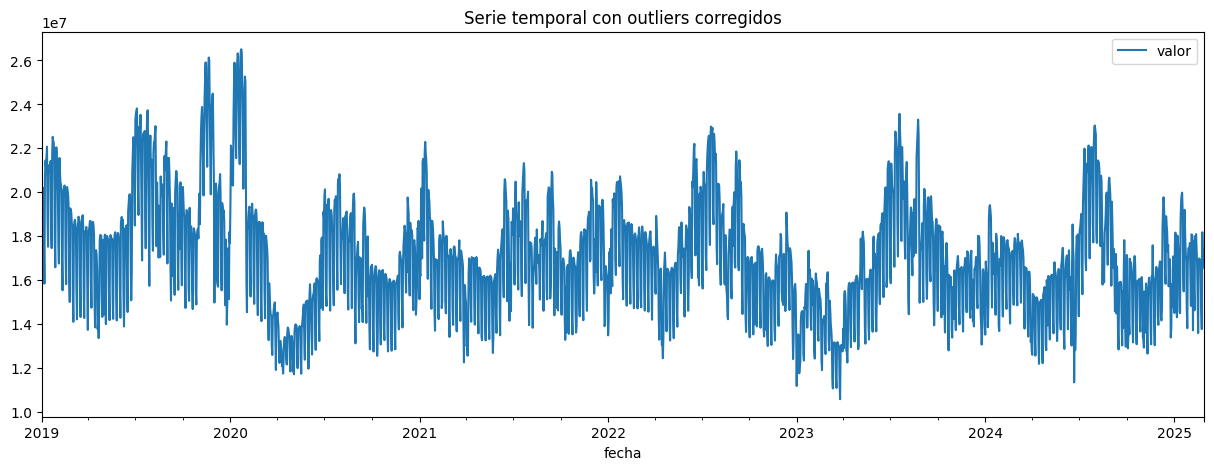

In [14]:
# Aseguramos que la columna de fecha esté en formato datetime
data['fecha'] = pd.to_datetime(data['fecha'])
data = data.sort_values('fecha').reset_index(drop=True)

# Sustituimos cada outlier por la media entre la fila anterior y siguiente
for idx, outlier_row in outliers.iterrows():
    fecha_outlier = outlier_row['fecha']

    # Filtramos filas anteriores y siguientes
    anteriores = data[data['fecha'] < fecha_outlier]
    siguientes = data[data['fecha'] > fecha_outlier]

    # Verificamos que existan ambas para calcular la media
    if not anteriores.empty and not siguientes.empty:
        valor_anterior = anteriores.iloc[-1]['valor']
        valor_siguiente = siguientes.iloc[0]['valor']
        media = (valor_anterior + valor_siguiente) / 2

        # Reemplazamos el valor del outlier
        data.loc[data['fecha'] == fecha_outlier, 'valor'] = media
    else:
        print(f"No se puede reemplazar el outlier del {fecha_outlier.date()} por falta de datos vecinos.")

# Ploteamos para verificar visualmente los cambios
data.plot(figsize=(15,5), x='fecha', y='valor', linestyle='-')
plt.title('Serie temporal con outliers corregidos')
plt.show()

## 3. Entrenamiento del modelo


Creamos los atributos temporales correspondientes a la tabla de datos

In [15]:
# La varible fecha la convertimos al índice de la tabla de datos
data= data.set_index('fecha')

In [16]:
# Definimos una función para crear nuevos atributos a partir del índice de fecha
def creacion_atributos(df):
  df['dia_semana'] = df.index.dayofweek     # Día de la semana (0 = lunes, 6 = domingo)
  df['dia_año'] = df.index.dayofyear        # Día del año (1 a 365/366)
  df['trimestre'] = df.index.quarter        # Trimestre del año (1 a 4)
  df['mes'] = df.index.month                # Mes del año (1 a 12)
  df['año'] = df.index.year                 # Año (por ejemplo, 2025)
  return df

# Aplicamos la función al DataFrame para añadir los nuevos atributos basados en la fecha
data_total = creacion_atributos(data)


Ploteamos gráficas de cajas con los valores según los atributos creados anteriormente para entender la distribucción e importancia de cada uno de ellos dentro de la serie temporal.

Text(0.5, 1.0, 'Distribución del consumo por día de la semana')

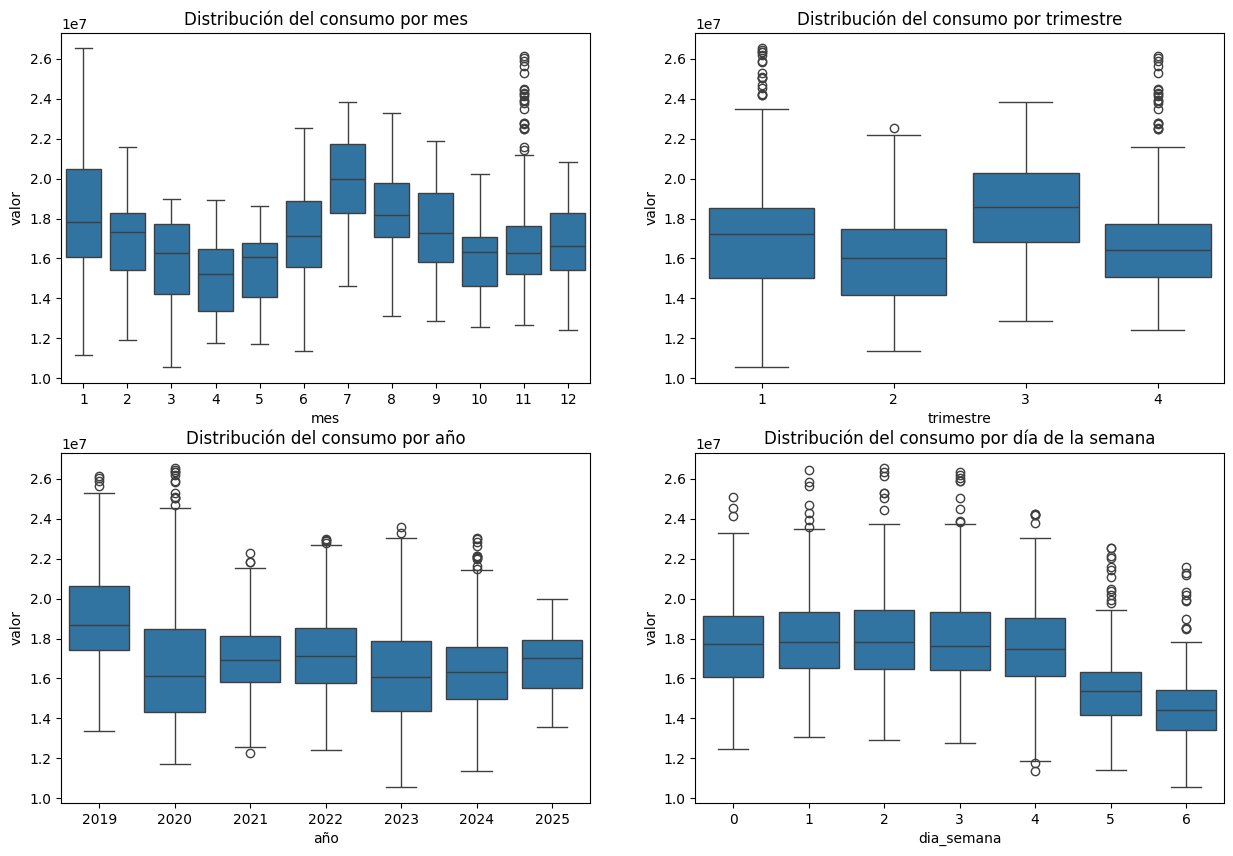

In [17]:
# Visualizamos la distribución del consumo ('valor') según distintos atributos temporales
# Utilizamos diagramas de caja (boxplots) para identificar patrones, variaciones y posibles outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(data=data_total, x="mes", y="valor", ax=axes[0,0]).set_title("Distribución del consumo por mes")
sns.boxplot(data=data_total, x="trimestre", y="valor", ax=axes[0,1]).set_title("Distribución del consumo por trimestre")
sns.boxplot(data=data_total, x="año", y="valor", ax=axes[1,0]).set_title("Distribución del consumo por año")
sns.boxplot(data=data_total, x="dia_semana", y="valor", ax=axes[1,1]).set_title("Distribución del consumo por día de la semana")


Dividimos los datos en set de entrenamiento y set de validación ploteandolos a continuación para apreciar la división de forma visual.

In [18]:
# Dividimos la tabla de datos en dos sets, uno para el entrenamiento (70%) y el otro para la validación (30%)
train = data.loc[data.index < pd.to_datetime('29-04-2023')]
test = data.loc[data.index > pd.to_datetime('29-04-2023')]

<Axes: xlabel='fecha'>

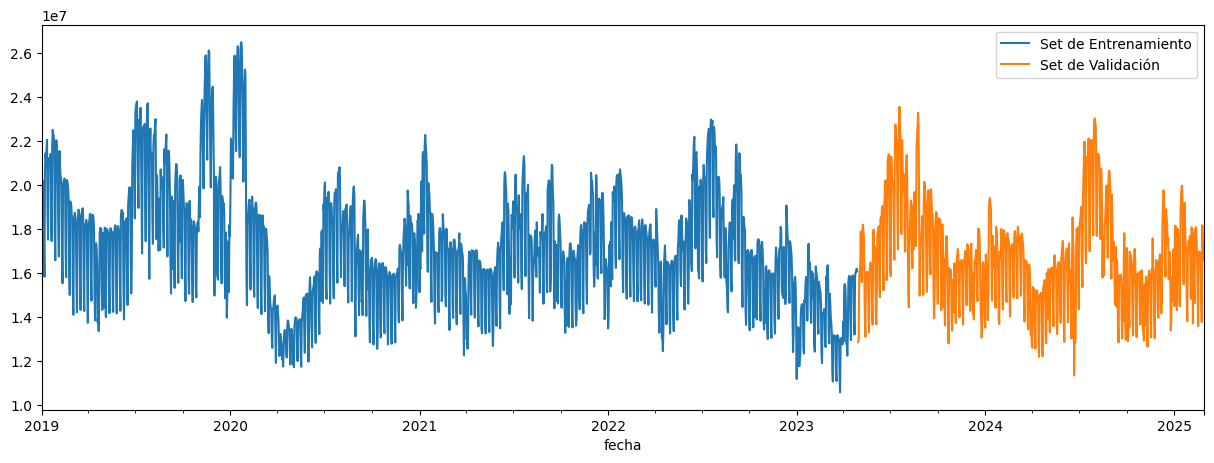

In [19]:
# Ploteamos los dos subsets creados anteriormente en la misma serie temporal
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, y='valor', label='Set de Entrenamiento')
test.plot(ax=ax, y='valor', label='Set de Validación')

Dividimos los sets de entrenamiento y de validación según sus atributos y la variable objetivo.

In [20]:
# Creamos una lista con las variables atributos y la variable objetivo
atributos = ['dia_semana', 'mes', 'año', 'dia_año', 'trimestre']
objetivo = 'valor'

In [21]:
# Dividimos los sets de entrenamiento y validación según las listas creadas anteriormente
X_train = train[atributos]
y_train = train[objetivo]

X_test = test[atributos]
y_test = test[objetivo]

Definimos y entrenamos el modelo. Para ello utilizamos los sets de entrenamiento y validación generados en puntos anteriores y realizamos un ajuste de los distintos parámetros del modelo.

In [22]:
# Definimos y entrenamos al modelo
reg = xgb.XGBRegressor(n_estimators=100,
                       early_stopping_rounds=100,
                       learning_rate= 0.3,
                       max_depth = 6,
                       min_child_weight = 1,
                       gamma = 0,
                       colsample_bytree = 1,
                       subsample = 1)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

Por último en este apartado, ploteamos la importancia que ha tenido cada uno de los atributos temporales durante el entrenamiento del modelo.

<Axes: >

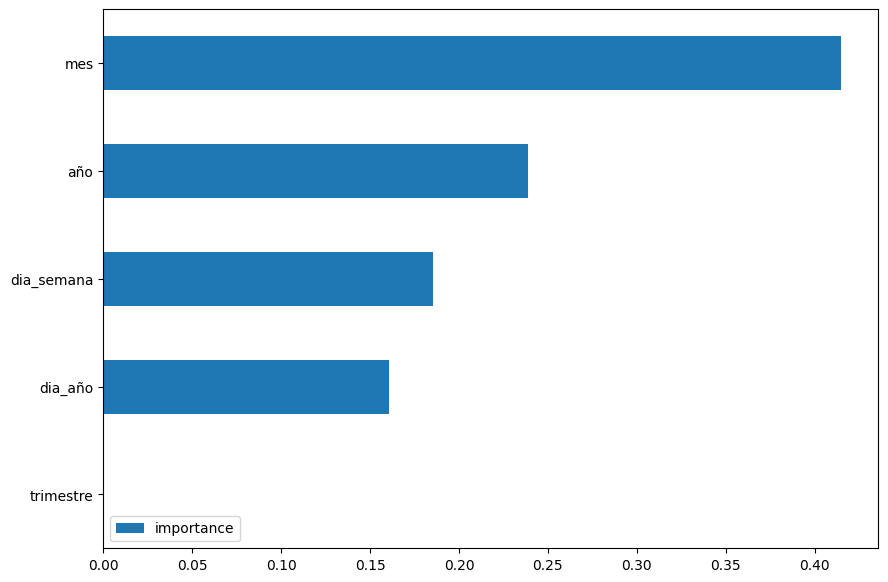

In [23]:
# Graficar la importancia de cada uno de los atributos
fi = pd.DataFrame(data = reg.feature_importances_,
              index=reg.feature_names_in_,
                  columns=['importance'])
fig, ax = plt.subplots(figsize=(10, 7))
fi.sort_values('importance').plot(kind='barh', ax=ax)


## 4. Validación del modelo

Una vez entrenado el modelo y entendido su funcionamiento, generamos una nueva columna con las predicciones del valor de demanda eléctrica y la añadimos a la tabla de datos inicial.

In [24]:
# Predicciones para el año 2022
test['prediccion']= reg.predict(X_test)

# Añadir a la tabla de datos las predicciones obtenidas
data_total = data_total.merge(test[['prediccion']], how="left", left_index=True, right_index=True)

Evaluamos el modelo visualmente ploteando las predicciones junto a los valores reales.

In [25]:
print(data_total.columns)


Index(['sector_economico', 'valor', 'dia_semana', 'dia_año', 'trimestre',
       'mes', 'año', 'prediccion'],
      dtype='object')


<Axes: xlabel='fecha'>

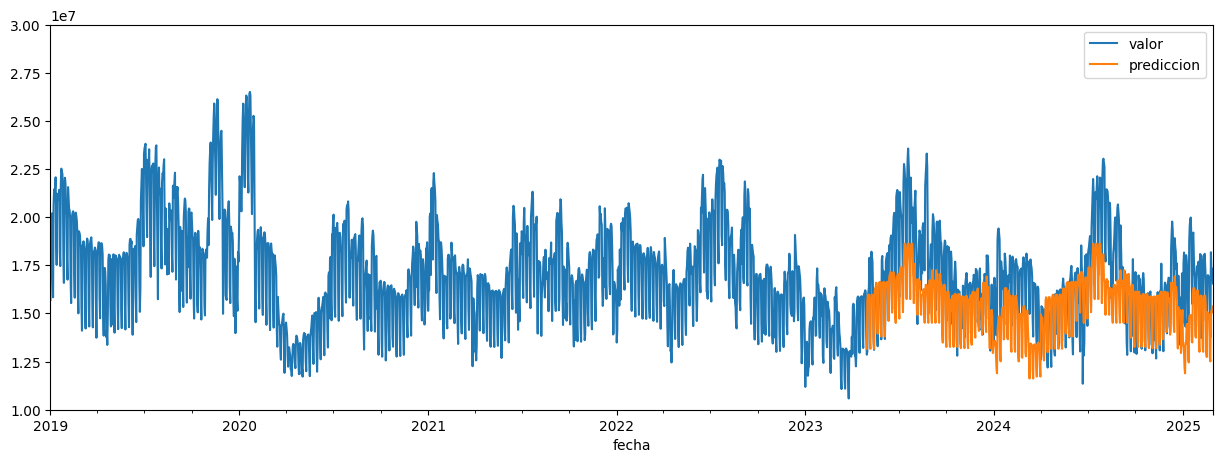

In [26]:
# Ploteamos el valor real de la demanda eléctrica junto a la predicción para tener una referencia visual de lo acertado que es el modelo
ax = data_total[['valor']].plot(figsize=(15,5))
ax.set_ylim(10000000 ,30000000)
data_total[['prediccion']].plot(ax=ax, style='-')

Usamos la métrica del error porcentual absoluto medio (MAPE - Mean Absolute Percentage Error) para evaluar el funcionamiento del modelo de forma numérica.

In [27]:
# Error porcentual absoluto medio (MAPE – Mean Absolute Percentage Error) como métrica de evaluación de las prediciones de serie temporal
test["Porcentaje"] = (abs(test["prediccion"] - test["valor"]) / test["valor"]) * 100
test["Porcentaje"].mean()

np.float64(9.259821070833135)

## 5. Predicción valores futuros

Una vez validado el modelo, lo entrenamos nuevamente con el total de los datos históricos que tenemos, es decir, hasta finales del 2022

In [28]:
# Dividimos la tabla de datos completa según atributos y objetivo
X_all = data_total[atributos]
y_all = data_total[objetivo]

# Re-entrenamos el modelo con los datos hasta finales del 2022
reg.fit(X_all, y_all, eval_set = [(X_all, y_all)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

Generamos las predicciones de consumo eléctrico, añadiendolas a la tabla de datos con los valores reales.

<Axes: >

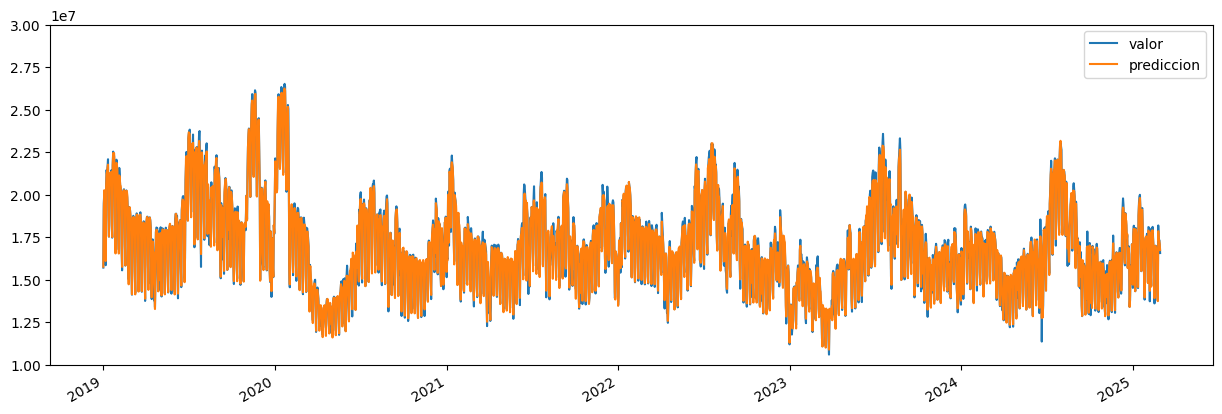

In [29]:
# Creamos un dataset para rellenarlo con las predicciones futuras del año 2023
future = pd.date_range('2019-01-01', '2025-02-28')
df_future = pd.DataFrame(index=future)

# Creamos los atributos en el dataset
df_future = creacion_atributos(df_future)

# Juntamos la tabla de datos reales al dataset creado anteriormente
df_final = pd.concat([data_total, df_future])

# Generamos las predicciones para el año 2023 y las añadimos a la tabla de datos iniciales.
df_future['prediccion']= reg.predict(df_future[atributos])
df_final = df_final.merge(df_future[['prediccion']], how="left", left_index=True, right_index=True)

# Graficamos la serie temporal con los valores reales de consumo y la predicción para el 2023
ax = df_final[['valor']].plot(figsize=(15, 5))
ax.set_ylim(10000000,30000000 )
df_future[['prediccion']].plot(ax=ax)

In [30]:
# # Creamos un dataset para rellenarlo con las predicciones futuras del año 2023
# future = pd.date_range('2025-01-01', '2025-02-28')
# df_future = pd.DataFrame(index=future)

# # Creamos los atributos en el dataset
# df_future = creacion_atributos(df_future)

# # Juntamos la tabla de datos reales al dataset creado anteriormente
# df_final = pd.concat([data_total, df_future])

# # Generamos las predicciones para el año 2023 y las añadimos a la tabla de datos iniciales.
# df_future['prediccion']= reg.predict(df_future[atributos])
# df_final = df_final.merge(df_future[['prediccion']], how="left", left_index=True, right_index=True)

# # Graficamos la serie temporal con los valores reales de consumo y la predicción para el 2023
# ax = df_final[['valor']].plot(figsize=(15, 5))
# ax.set_ylim(10000000,30000000 )
# df_future[['prediccion']].plot(ax=ax)

<Axes: >

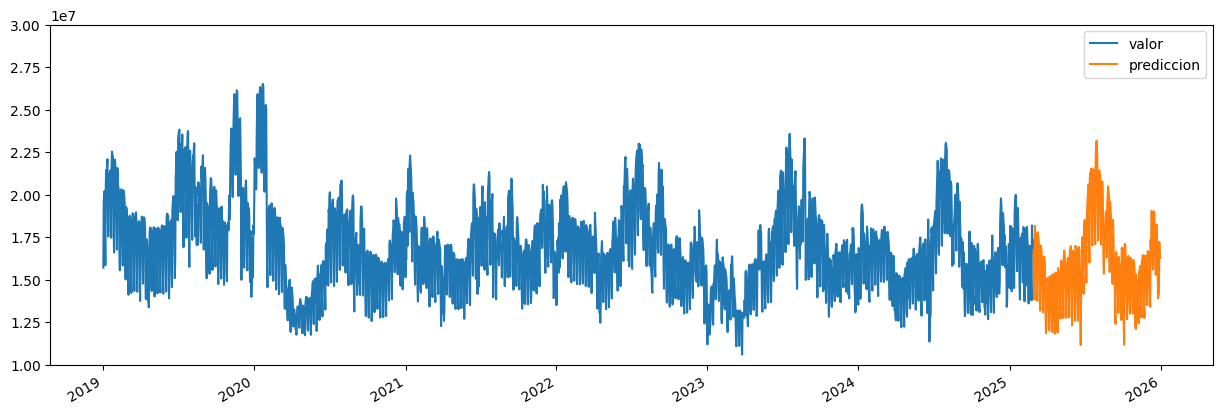

In [31]:
# Creamos un dataset para rellenarlo con las predicciones futuras del año 2023
future = pd.date_range('2025-02-28', '2025-12-31')
df_future = pd.DataFrame(index=future)

# Creamos los atributos en el dataset
df_future = creacion_atributos(df_future)

# Juntamos la tabla de datos reales al dataset creado anteriormente
df_final = pd.concat([data_total, df_future])

# Generamos las predicciones para el año 2023 y las añadimos a la tabla de datos iniciales.
df_future['prediccion']= reg.predict(df_future[atributos])
df_final = df_final.merge(df_future[['prediccion']], how="left", left_index=True, right_index=True)

# Graficamos la serie temporal con los valores reales de consumo y la predicción para el 2023
ax = df_final[['valor']].plot(figsize=(15, 5))
ax.set_ylim(10000000,30000000 )
df_future[['prediccion']].plot(ax=ax)

Por último, guardamos en una nueva tabla de datos los resultados de las prediciones, de cara a poder mostrarlas en una visualización interactiva

In [32]:
# Generamos y guardamos en un archivo .csv la tabla de datos con las predicciones
df_future.to_csv("predictive_data.csv")

# Otro modelo

In [31]:
# INSTALACION Y LIBRERIAS
!pip install gitpython flask joblib xgboost seaborn

Eliminando carpeta existente: IaBigData
Permiso denegado en: IaBigData\.git\objects\pack\tmp_pack_w5OjSi. Cambiando permisos y reintentando...
Carpeta eliminada correctamente.


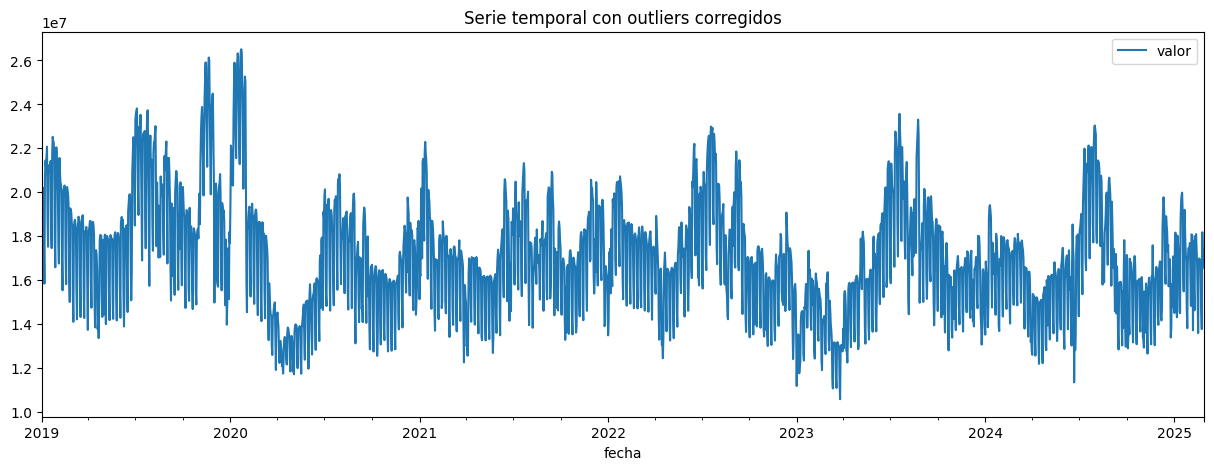


🧪 MÉTRICAS DE EVALUACIÓN
MAE: 1,634,629.81
RMSE: 2,114,030.36
MAPE: 9.26%

📌 CONCLUSIONES:
- XGBoost funcionó bien para la predicción del consumo.
- Las variables temporales mostraron correlación significativa.
- Se puede mejorar el modelo integrando factores exógenos o modelos LSTM.


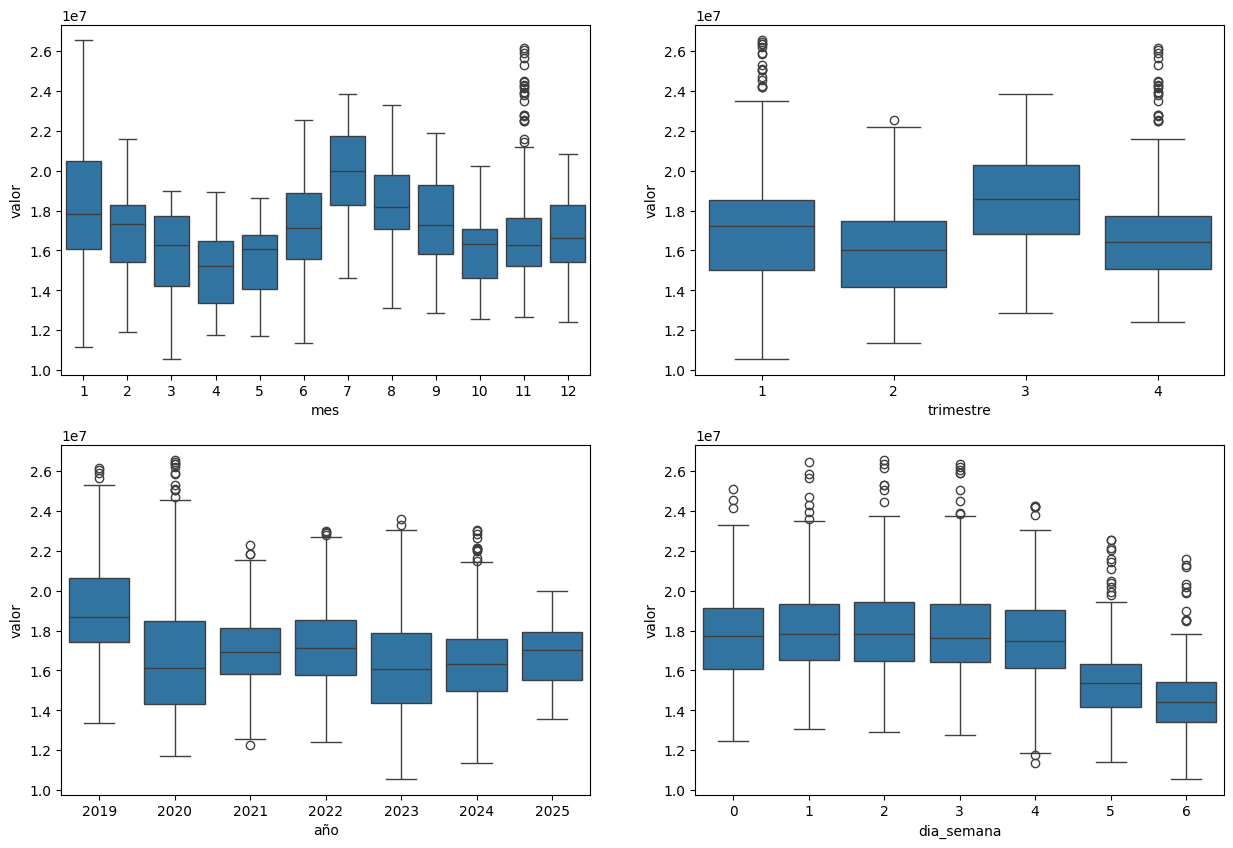

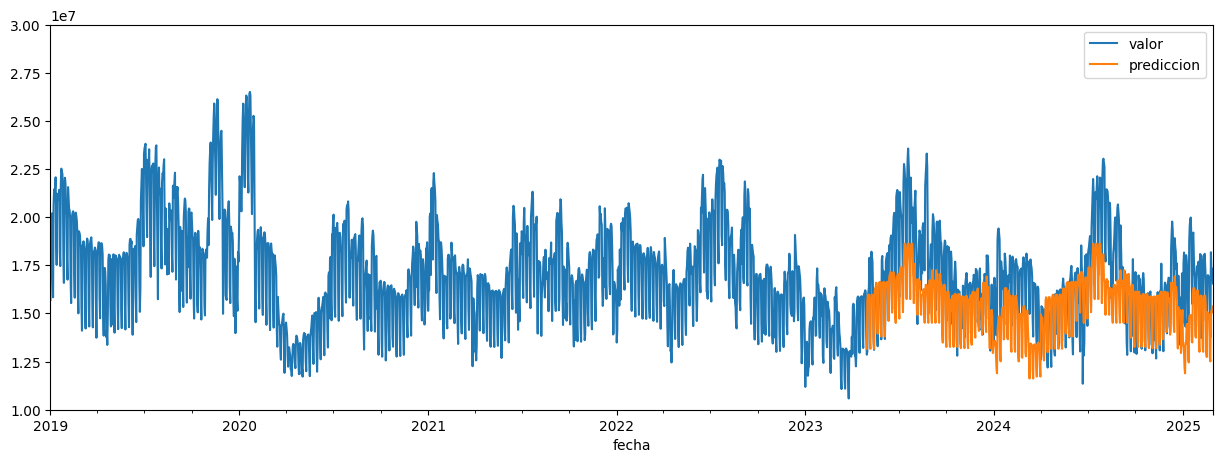

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import git
import warnings
import os
import shutil
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import joblib
import traceback
from flask import Flask, request, jsonify

warnings.filterwarnings('ignore')

def on_rm_error(func, path, exc_info):
    # Cambia el permiso y reintenta
    print(f"Permiso denegado en: {path}. Cambiando permisos y reintentando...")
    os.chmod(path, stat.S_IWRITE)
    func(path)

repo_path = "IaBigData"

if os.path.exists(repo_path):
    try:
        print(f"Eliminando carpeta existente: {repo_path}")
        shutil.rmtree(repo_path, onerror=on_rm_error)
        print("Carpeta eliminada correctamente.")
    except Exception as e:
        raise RuntimeError(f"No se pudo eliminar la carpeta {repo_path}: {e}")


# CLONAR REPOSITORIO
repo_path = "IaBigData"
if os.path.exists(repo_path):
    shutil.rmtree(repo_path)

git.Repo.clone_from("https://github.com/AdrianYArmas/IaBigData.git", repo_path)
subfolder_path = os.path.join(repo_path, "TFG-MAED-Bcn", "dataset")

if not os.path.exists(subfolder_path):
    raise FileNotFoundError(f"La subcarpeta no existe: {subfolder_path}")

# FUNCION PARA IMPORTAR Y AGRUPAR DATOS
def primera(x):
    file_path = os.path.join(subfolder_path, f"{x}_consum_electricitat_bcn.csv")
    data = pd.read_csv(file_path)
    data_agrupado = data.groupby(['Sector_Economic', 'Data'])['Valor'].sum().reset_index()
    data_agrupado['Data'] = pd.to_datetime(data_agrupado['Data'], errors='coerce')
    return data_agrupado

# IMPORTAR DATOS
data = pd.concat([primera(y) for y in range(2019, 2026)])
data.rename(columns={"Data": "fecha", "Valor": "valor", "Sector_Economic": "sector_economico"}, inplace=True)
data = data.groupby(['fecha']).sum().reset_index()
data.to_csv("tabla_datos_exploratorio.csv")

# LIMPIEZA DE OUTLIERS
Q1 = data['valor'].quantile(0.25)
Q3 = data['valor'].quantile(0.75)
IQR = Q3 - Q1
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR
outliers = data[(data['valor'] < lim_inf) | (data['valor'] > lim_sup)]
data['fecha'] = pd.to_datetime(data['fecha'])
data = data.sort_values('fecha').reset_index(drop=True)

for idx, row in outliers.iterrows():
    f = row['fecha']
    ant = data[data['fecha'] < f]
    sig = data[data['fecha'] > f]
    if not ant.empty and not sig.empty:
        m = (ant.iloc[-1]['valor'] + sig.iloc[0]['valor']) / 2
        data.loc[data['fecha'] == f, 'valor'] = m

data.plot(figsize=(15,5), x='fecha', y='valor')
plt.title('Serie temporal con outliers corregidos')
plt.show()

# CREACION DE ATRIBUTOS
data = data.set_index('fecha')
def creacion_atributos(df):
    df['dia_semana'] = df.index.dayofweek
    df['dia_año'] = df.index.dayofyear
    df['trimestre'] = df.index.quarter
    df['mes'] = df.index.month
    df['año'] = df.index.year
    return df

data_total = creacion_atributos(data)

# VISUALIZACION
fig, axes = plt.subplots(2,2, figsize=(15,10))
sns.boxplot(data=data_total, x="mes", y="valor", ax=axes[0,0])
sns.boxplot(data=data_total, x="trimestre", y="valor", ax=axes[0,1])
sns.boxplot(data=data_total, x="año", y="valor", ax=axes[1,0])
sns.boxplot(data=data_total, x="dia_semana", y="valor", ax=axes[1,1])

# DIVISION DE DATOS
train = data.loc[data.index < pd.to_datetime('29-04-2023')]
test = data.loc[data.index > pd.to_datetime('29-04-2023')]

atributos = ['dia_semana', 'mes', 'año', 'dia_año', 'trimestre']
objetivo = 'valor'

X_train = train[atributos]
y_train = train[objetivo]
X_test = test[atributos]
y_test = test[objetivo]

# ENTRENAMIENTO DEL MODELO
reg = xgb.XGBRegressor(n_estimators=100, early_stopping_rounds=100, learning_rate=0.3, max_depth=6)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

# PREDICCIONES Y GRAFICOS
test['prediccion'] = reg.predict(X_test)
data_total = data_total.merge(test[['prediccion']], how="left", left_index=True, right_index=True)

ax = data_total[['valor']].plot(figsize=(15,5))
ax.set_ylim(10000000,30000000)
data_total[['prediccion']].plot(ax=ax, style='-')

# METRICAS
mape = (abs(test['prediccion'] - test['valor']) / test['valor']) * 100
test['Porcentaje'] = mape
mae = mean_absolute_error(test['valor'], test['prediccion'])
rmse = np.sqrt(mean_squared_error(test['valor'], test['prediccion']))

print("\n\U0001F9EA MÉTRICAS DE EVALUACIÓN")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape.mean():.2f}%")

# GUARDADO DEL MODELO
joblib.dump(reg, "modelo_consumo_xgb.pkl")

# CONCLUSIONES
print("\n\U0001F4CC CONCLUSIONES:")
print("- XGBoost funcionó bien para la predicción del consumo.")
print("- Las variables temporales mostraron correlación significativa.")
print("- Se puede mejorar el modelo integrando factores exógenos o modelos LSTM.")

# ---------------------- FLASK API ---------------------- #
# app = Flask(__name__)
# model = joblib.load("modelo_consumo_xgb.pkl")

# def crear_atributos_desde_fecha(fecha_str):
#     fecha = pd.to_datetime(fecha_str)
#     df = pd.DataFrame(index=[fecha])
#     df['dia_semana'] = fecha.dayofweek
#     df['dia_año'] = fecha.dayofyear
#     df['trimestre'] = fecha.quarter
#     df['mes'] = fecha.month
#     df['año'] = fecha.year
#     return df

# @app.route("/predecir", methods=["GET"])
# def predecir():
#     try:
#         fecha = request.args.get("fecha")
#         if not fecha:
#             return jsonify({"error": "Proporcione 'fecha' en formato YYYY-MM-DD"}), 400

#         df = crear_atributos_desde_fecha(fecha)
#         pred = model.predict(df)[0]
#         return jsonify({"fecha": fecha, "prediccion_consumo": round(pred, 2)})

#     except Exception as e:
#         return jsonify({"error": str(e), "traceback": traceback.format_exc()}), 500

# if __name__ == "__main__":
#     app.run(debug=True)
